# Загрузим данные 

In [1]:
!kaggle datasets download heeraldedhia/groceries-dataset -p "C:\Files\Программирование\Портфолио\Market Basket Analysis\data"

Dataset URL: https://www.kaggle.com/datasets/heeraldedhia/groceries-dataset
License(s): GPL-2.0




  0%|          | 0.00/257k [00:00<?, ?B/s]
100%|██████████| 257k/257k [00:01<00:00, 256kB/s]
100%|██████████| 257k/257k [00:01<00:00, 256kB/s]


In [2]:
%%capture
import os
from shutil import unpack_archive

unpack_archive('data/groceries-dataset.zip', './data', 'zip')

os.remove('data/groceries-dataset.zip')

# Импортируем библиотеки

In [3]:
import pandas as pd

# Посмотрим данные

In [4]:
df = pd.read_csv('data/Groceries_dataset.csv')

In [5]:
df.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


Переименуем столбцы

In [6]:
df.rename(columns={'Member_number': 'id', 'Date': 'date', 'itemDescription': 'product_name'}, inplace=True)

In [7]:
df

,id,date,product_name
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk
...,...,...,...
38760,4471,08-10-2014,sliced cheese
38761,2022,23-02-2014,candy
38762,1097,16-04-2014,cake bar
38763,1510,03-12-2014,fruit/vegetable juice


Посмотрим на пропуски и распределение

In [8]:
df.isna().sum()

id              0
date            0
product_name    0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            38765 non-null  int64 
 1   date          38765 non-null  object
 2   product_name  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


Приведем типы

In [10]:
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

In [11]:
df['product_name'] = df['product_name'].astype('string')

Посмотрим нет ли покупателей с аномальным количеством покупок

In [12]:
df['id'].value_counts()

id
3180    36
3737    33
3050    33
2051    33
3915    31
        ..
4590     2
4703     2
3607     2
4587     2
2417     2
Name: count, Length: 3898, dtype: int64

<Axes: >

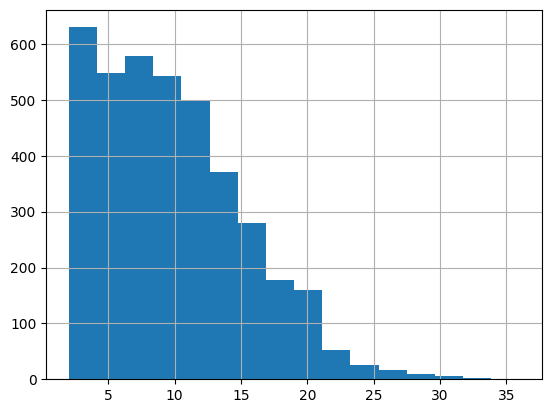

In [13]:
df['id'].value_counts().hist(bins=16)

# Анализ сочетаемости

Сформируем чеки

In [14]:
df_group = df.groupby(by=['id', 'date'])['product_name'].apply(list).reset_index()

In [15]:
df_group

,id,date,product_name
0,1000,2014-06-24,"[whole milk, pastry, salty snack]"
1,1000,2015-03-15,"[sausage, whole milk, semi-finished bread, yog..."
2,1000,2015-05-27,"[soda, pickled vegetables]"
3,1000,2015-07-24,"[canned beer, misc. beverages]"
4,1000,2015-11-25,"[sausage, hygiene articles]"
...,...,...,...
14958,4999,2015-05-16,"[butter milk, whipped/sour cream]"
14959,4999,2015-12-26,"[bottled water, herbs]"
14960,5000,2014-03-09,"[fruit/vegetable juice, onions]"
14961,5000,2014-11-16,"[bottled beer, other vegetables]"


Получили почти 15к чеков, проверим есть ли чеки с одним товаром и удалим их

In [16]:
df_group['size'] = df_group['product_name'].apply(len)

In [17]:
df_group['size'].describe()

count    14963.000000
mean         2.590724
std          1.117469
min          2.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         11.000000
Name: size, dtype: float64

Минимум 2 товара в чеке, можем делать пары

In [46]:
from itertools import combinations

products_pair = []

for i in range(len(df_group)):
    current_check = list(sorted(df_group.loc[i, 'product_name']))
    pairs = list(combinations(current_check, 2))
    
    for j in pairs:
        pair = ' - '.join(j)
        products_pair.append(pair)

In [47]:
pairs = pd.DataFrame({'pair': products_pair})

In [48]:
pairs

,pair
0,pastry - salty snack
1,pastry - whole milk
2,salty snack - whole milk
3,sausage - semi-finished bread
4,sausage - whole milk
...,...
40169,fruit/vegetable juice - onions
40170,bottled beer - other vegetables
40171,root vegetables - semi-finished bread
40172,root vegetables - soda


Получили больше 40к пар товаров, подсчитаем количество каждой пары

In [49]:
pair_count = pairs['pair'].value_counts().reset_index()

In [50]:
pairs_merge = pairs.merge(pair_count, on='pair', how='left')

In [51]:
pairs_merge['count'].describe()

count    40174.000000
mean        33.128342
std         43.102350
min          1.000000
25%          6.000000
50%         17.000000
75%         43.000000
max        243.000000
Name: count, dtype: float64

<Axes: >

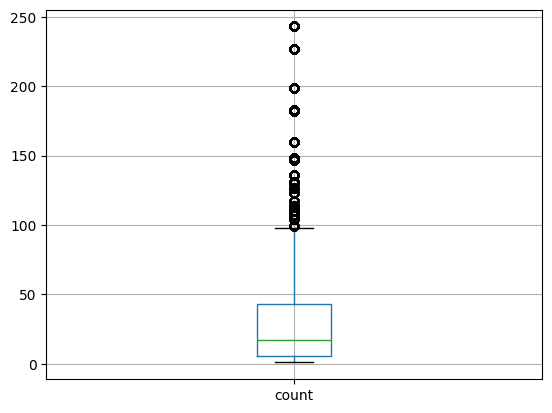

In [52]:
pairs_merge.boxplot(column='count')

Не будем удалять "выбросы", добавим в dataframe столбцы с разделенными товарами

In [53]:
pairs_merge['first_product'] = pairs['pair'].apply(lambda x: x.split(' - ')[0])
pairs_merge['second_product'] = pairs['pair'].apply(lambda x: x.split(' - ')[1])

In [54]:
pairs_merge['first_product'].value_counts()

first_product
other vegetables         1878
bottled water            1706
bottled beer             1393
canned beer              1309
citrus fruit             1282
                         ... 
specialty vegetables        4
kitchen utensil             2
whisky                      1
preservation products       1
toilet cleaner              1
Name: count, Length: 166, dtype: int64

In [55]:
pairs_merge['second_product'].value_counts()

second_product
whole milk          4884
yogurt              2740
soda                2400
rolls/buns          2280
other vegetables    1880
                    ... 
kitchen utensil        2
frozen chicken         2
artif. sweetener       1
abrasive cleaner       1
baby cosmetics         1
Name: count, Length: 163, dtype: int64

In [56]:
df['product_name'].nunique()

167

Имеем представление о продажах товаров. Посмотим период продаж, что бы понимать сроки

In [33]:
df['date'].max() - df['date'].min()

Timedelta('728 days 00:00:00')

Разделим товары на 3 категории в зависимости от их доли в общих продажах

In [99]:
product_count = df['product_name'].value_counts().reset_index()

In [102]:
all_count = product_count['count'].sum()

In [103]:
product_count['fraction'] = product_count['count'].apply(lambda x: (x/all_count) * 100)

In [109]:
product_count = product_count.sort_values(by='fraction', ascending=False)

Сделаем накопительным итогом проценты

In [111]:
product_count['cumsum'] = product_count['fraction'].cumsum()

Посмотрим сколько товаров в каких границах лежит

In [123]:
product_count[product_count['cumsum'] <= 70].shape[0] / product_count.shape[0]

0.20958083832335328

In [124]:
product_count[(product_count['cumsum'] > 70) & (product_count['cumsum'] <= 95)].shape[0] / product_count.shape[0]

0.3652694610778443

In [125]:
product_count[product_count['cumsum'] > 95].shape[0] / product_count.shape[0]

0.4251497005988024

Товарам в определенных границах присвоим категорию и добавим в наш датасет с парами

In [126]:
product_count.loc[product_count['cumsum'] <= 70, 'group'] = 'A'

In [127]:
product_count.loc[(product_count['cumsum'] > 70) & (product_count['cumsum'] <= 95), 'group'] = 'B'

In [128]:
product_count.loc[product_count['cumsum'] > 95, 'group'] = 'C'

In [130]:
product_count['group'].value_counts() / product_count.shape[0]

group
C    0.425150
B    0.365269
A    0.209581
Name: count, dtype: float64

In [132]:
pairs_merge

,pair,count,first_product,second_product,pair_list
0,pastry - salty snack,10,pastry,salty snack,"[pastry, salty snack]"
1,pastry - whole milk,104,pastry,whole milk,"[pastry, whole milk]"
2,salty snack - whole milk,33,salty snack,whole milk,"[salty snack, whole milk]"
3,sausage - semi-finished bread,9,sausage,semi-finished bread,"[sausage, semi-finished bread]"
4,sausage - whole milk,147,sausage,whole milk,"[sausage, whole milk]"
...,...,...,...,...,...
40169,fruit/vegetable juice - onions,1,fruit/vegetable juice,onions,"[fruit/vegetable juice, onions]"
40170,bottled beer - other vegetables,72,bottled beer,other vegetables,"[bottled beer, other vegetables]"
40171,root vegetables - semi-finished bread,10,root vegetables,semi-finished bread,"[root vegetables, semi-finished bread]"
40172,root vegetables - soda,83,root vegetables,soda,"[root vegetables, soda]"


In [148]:
pairs_with_first_group = pairs_merge.merge(product_count, left_on='first_product', right_on='product_name', how='left').drop(columns=['product_name', 'count_y', 'fraction', 'cumsum']).rename(columns={'count_x': 'pair_count', 'group': 'first_product_group'})

In [152]:
pairs_with_groups = pairs_with_first_group.merge(product_count, left_on='second_product', right_on='product_name', how='left').drop(columns=['product_name', 'count', 'fraction', 'cumsum']).rename(columns={'group': 'second_product_group'})

In [153]:
pairs_with_groups

,pair,pair_count,first_product,second_product,first_product_group,second_product_group
0,pastry - salty snack,10,pastry,salty snack,A,B
1,pastry - whole milk,104,pastry,whole milk,A,A
2,salty snack - whole milk,33,salty snack,whole milk,B,A
3,sausage - semi-finished bread,9,sausage,semi-finished bread,A,B
4,sausage - whole milk,147,sausage,whole milk,A,A
...,...,...,...,...,...,...
40169,fruit/vegetable juice - onions,1,fruit/vegetable juice,onions,A,B
40170,bottled beer - other vegetables,72,bottled beer,other vegetables,A,A
40171,root vegetables - semi-finished bread,10,root vegetables,semi-finished bread,A,B
40172,root vegetables - soda,83,root vegetables,soda,A,A


Зная количество пар и категорию каждого товара, можем составить пары, для повышения продаж определенных товаров

Если какой-то товар покупают чаще в паре с другим и при этом у одного из товаров группа ниже, то предлагая акции этой пары, мы сможем поднять его продажи

In [ ]:
def get_pairs(product_name, max_pairs=3):
    print()
    print(f'Пары для: {product_name} '.center(50, '-'))
    # Получим категорию товара
    # Если категория A, то разумнее будет сконцентрироваться на других товарах
    product_group = product_count.loc[product_count['product_name'] == product_name, 'group'].values[0]

    print(f'Категория товара: {product_group}')

    if product_group == 'A':
        print('Категория продукта А. Лучше сконцентрироваться на других товарах', end='\n\n')
        return

    # Выберем категорию на одну выше (B -> A, C -> B)
    need_group = ''
    if product_group == 'B':
        need_group = 'A'
    else:
        need_group = 'C'

    # Выберем все пары с нашим продуктом и с продуктами на категорию выше
    if_first_product = ((pairs_with_groups['first_product'] == product_name) & (pairs_with_groups['second_product_group'] == need_group))
    if_second_product = ((pairs_with_groups['second_product'] == product_name) & (pairs_with_groups['first_product_group'] == need_group))
    pairs = pairs_with_groups.loc[(if_first_product | if_second_product)]

    if pairs.shape[0] == 0:
        print('Нет пар с товаром на категорию выше')
        return
    
    pairs = pairs.sort_values(by='pair_count', ascending=False)
    pairs.drop_duplicates(subset=['pair'], inplace=True)

    # Если пар больше max_pairs, то ограничиваем вывод
    if pairs.shape[0] > max_pairs:
        pairs = pairs.iloc[:max_pairs]
        
    pairs_list = pairs['pair'].apply(lambda x: x.split(' - ')).tolist()

    best_vars = set()
    best_vars.update(*pairs_list)
    best_vars.remove(product_name)

    print(f'Лучшие товары для акции: {', '.join(best_vars)}')


In [267]:
test_products = product_count['product_name'].sample(5).tolist()

for i in test_products:
    get_pairs(i)


-------------Пары для: spread cheese -------------
Категория товара: B
Лучшие товары для акции: sausage, whole milk, other vegetables

---------------Пары для: zwieback ----------------
Категория товара: C
Лучшие товары для акции: jam, curd cheese, rice

-----------Пары для: bathroom cleaner ------------
Категория товара: C
Лучшие товары для акции: popcorn

---------Пары для: specialty vegetables ----------
Категория товара: C
Нет пар с товаром на категорию выше

-----------Пары для: other vegetables ------------
Категория товара: A
Категория продукта А. Лучше сконцентрироваться на других товарах



# Вывод

На данных о продажах, Мы смогли:  
 - Выделить пары товаров  
 - Провести ABC анализ для товаров
 - Написать программу для рекомедации наиболее подходящего товара